In [1]:
%cd /Users/nicola/Desktop/sigoptim/kernel_hedge

import sigkernel
import numpy as np
import torch
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import scipy.stats as scipy
from scipy.stats import norm
from src.utils import augment_with_time

from src.kernel_compute import KernelCompute
from src.kernel_hedger_lean import KernelHedger
from src.kernel_trader_lean import KernelTrader

if torch.cuda.is_available(): 
  device = 'cuda'
else: 
  device = 'cpu'

print('device:', device)

%matplotlib inline

/Users/nicola/Desktop/sigoptim/kernel_hedge
device: cpu


# Hedging

## Preliminaries

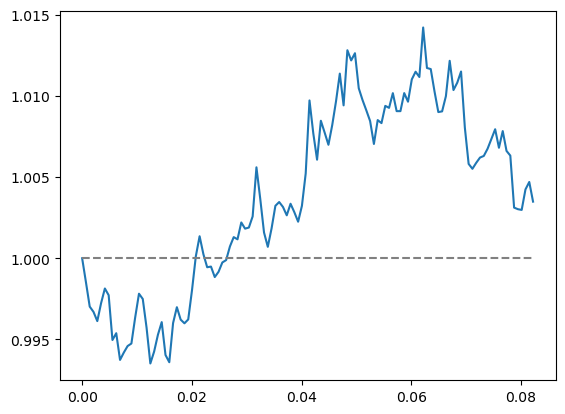

In [38]:
torch.manual_seed(0)
batch_x, batch_y, timesteps, d = 200, 100, 120, 1
sigma, strike, S0, T = 0.05, 1.0, 1.0, 30./365 # Black Scholes parameters


dt = T/timesteps
time_grid = torch.linspace(0.0, T, timesteps).view(1, -1, 1).expand([batch_x + batch_y, timesteps, d])

dW = np.sqrt(dt)*torch.randn(batch_x + batch_y, timesteps-1, d)
W = torch.cat((torch.zeros(batch_x + batch_y, 1, d), dW.cumsum(dim=1)), dim = 1)
S = S0*torch.exp(-0.5*(sigma**2)*time_grid + sigma*W).to(device)

train_paths = S[:batch_x]
test_paths = S[batch_x:]

plt.plot(torch.linspace(0.0, T, timesteps), S[0].detach().cpu())
plt.plot(torch.linspace(0.0, T, timesteps), strike*torch.ones(timesteps), '--', color = 'grey')
plt.show()

In [39]:
#Blackscholes price

def BS(S0, strike, T, sigma):
    return S0*scipy.norm.cdf((np.log(S0/strike)+0.5*T*sigma**2)/(np.sqrt(T)*sigma))-strike*scipy.norm.cdf((np.log(S0/strike)-0.5*T*sigma**2)/(np.sqrt(T)*sigma))


strike_K = strike
def EuropeanCall(S):
  S = S.cpu()
  temp_fn = np.vectorize(lambda x : torch.max(torch.tensor([x - strike_K, 0.0])))
  return torch.tensor(temp_fn(S[:, -1, :])).to(device)


def delta_hedge(ttm, strike, sigma, r, curr_price):
  temp = torch.log(curr_price.cpu()/strike) + (r + 0.5*sigma**2)*ttm
  temp = temp/(sigma*np.sqrt(ttm))
  return  torch.tensor(norm.cdf(temp)).to(device)

priceBS = BS(S0,strike,T,sigma)
print('Price of a Call option in the Black scholes model with initial price', S0, 'strike', strike, 'maturity', T , 'and volatility' , sigma, 'is equal to', BS(S0,strike,T,sigma))

delta_hedge_ = torch.zeros(test_paths[:,:,0].shape).to(device)
for j in range(test_paths.shape[0]):
    for i in range(test_paths.shape[1]):
        ttm = T - i*T/timesteps
        delta_hedge_[j, i] = delta_hedge(ttm, strike, sigma, 0.0, test_paths[j,i,0])

Price of a Call option in the Black scholes model with initial price 1.0 strike 1.0 maturity 0.0821917808219178 and volatility 0.05 is equal to 0.0057186108908512945


In [40]:
def plot_results(test_index, kernel_hedge, delta_hedge, sign = 1):
    
    figure(figsize=(15, 12), dpi=80)
    
    kernel_position = kernel_hedge.position[test_index].detach().cpu()
    kernel_Phi = kernel_hedge.Phi[0, test_index].detach().cpu()
    delta = sign*delta_hedge[test_index].cpu()

    difference = delta[0] - kernel_position[0,0]
    print('Difference:', difference)

    plt.subplot(2, 2, 1)
    plt.plot(kernel_position, label='kernel')
    #plt.plot(kernel_position + difference, color='red', label='kernel + shift')
    plt.plot(delta, color='orange', label='delta')
    plt.legend()

    plt.subplot(2, 2, 2)
    plt.plot(kernel_Phi, label='Phi')
    plt.legend()

    plt.subplot(2, 2, 3)
    plt.plot(kernel_position, label='kernel')
    plt.legend()

    plt.subplot(2, 2, 4)
    plt.plot(delta, color='orange', label='delta')
    plt.legend()

    plt.show()
    
def plot_results_old(test_index, kernel_hedge, delta_hedge, sign = 1):
    
    figure(figsize=(15, 12), dpi=80)
    
    kernel_position = kernel_hedge.position[test_index].detach().cpu()
    kernel_Phi = kernel_hedge.Phi[test_index, 0].detach().cpu()
    delta = sign*delta_hedge[test_index].cpu()

    difference = delta[0] - kernel_position[0,0]
    print('Difference:', difference)

    plt.subplot(2, 2, 1)
    plt.plot(kernel_position, label='kernel')
    #plt.plot(kernel_position + difference, color='red', label='kernel + shift')
    plt.plot(delta, color='orange', label='delta')
    plt.legend()

    plt.subplot(2, 2, 2)
    plt.plot(kernel_Phi, label='Phi')
    plt.legend()

    plt.subplot(2, 2, 3)
    plt.plot(kernel_position, label='kernel')
    plt.legend()

    plt.subplot(2, 2, 4)
    plt.plot(delta, color='orange', label='delta')
    plt.legend()

    plt.show()
    
def plot_results_zoom(test_index, kernel_hedge, delta_hedge, sign = 1):
    
    figure(figsize=(15, 12), dpi=80)
    
    kernel_position = kernel_hedge.position[test_index].detach().cpu()
    delta = sign*delta_hedge[test_index].cpu()

    difference = delta[0] - kernel_position[0,0]
    print('Difference:', difference)

    plt.subplot(2, 1, 1)
    plt.plot(kernel_position, label='kernel')
    plt.plot(kernel_position + difference, color='red', label='kernel + shift')
    plt.plot(delta, color='orange', label='delta')
    plt.legend()

    plt.show()

## Body

In [76]:
class SigKer(KernelCompute):
    def __init__(self):
        self.dyadic_order = 0
        self.Kernel_Class = sigkernel.SigKernel(sigkernel.LinearKernel(), dyadic_order=self.dyadic_order)
        self.scale = 2
        
    def compute_Gram(self, X, Y, sym=False):
        return self.Kernel_Class.compute_Gram(self.scale*X.double(),self.scale*Y.double(), sym=sym)[..., ::2**self.dyadic_order, ::2**self.dyadic_order]
    
    def K_Phi(self, X, time_augmented=False, max_batch=50):
        return super().K_Phi(X, time_augmented, max_batch)

In [77]:
Ker = SigKer()
X, Y = augment_with_time(train_paths), augment_with_time(test_paths)

# Phi = Ker.Phi(X, Y, time_augmented=True)
# K_Phi = Ker.K_Phi(X, time_augmented=True)

sk_hedge = KernelHedger(Ker,
                        EuropeanCall, priceBS, 
                        device, time_augment=True)

sk_hedge.pre_fit(train_paths)

Difference: tensor(0.0095, dtype=torch.float64)


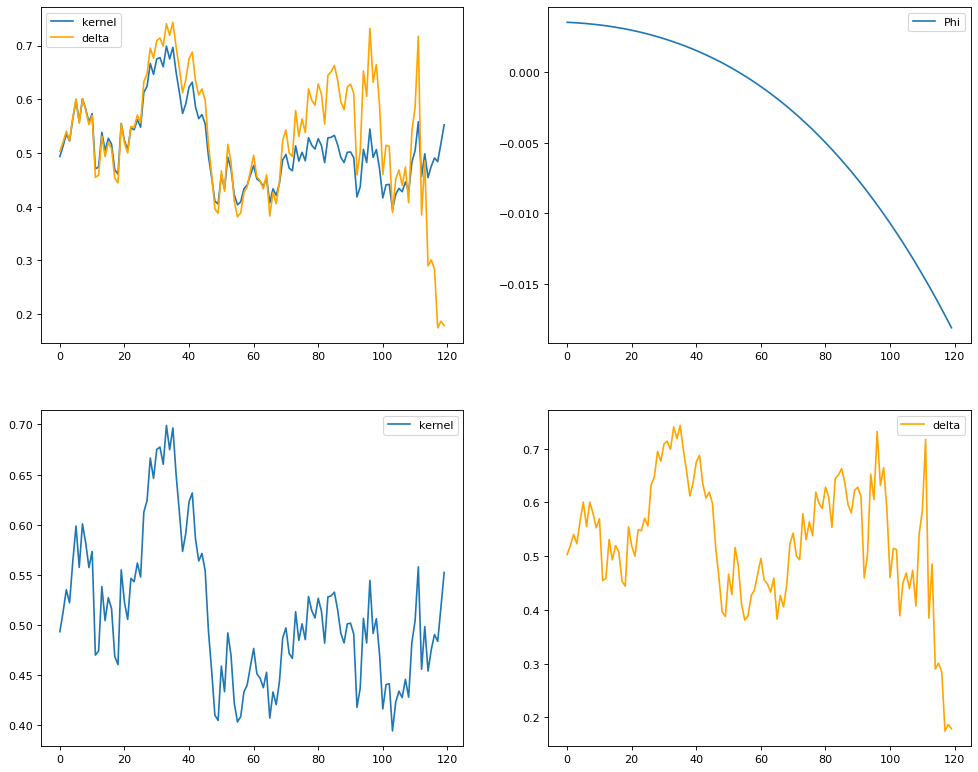

In [83]:
sk_hedge.fit(regularisation=1e-7*sk_hedge.Xi.norm())
sk_hedge.compute_pnl(test_paths)

plot_results(0, sk_hedge, delta_hedge_)

# Trading

## Preliminaries

### Data Creation

$$X_t = X_t$$
$$Y_t = X_t + Z_t$$

with $X_t$ a 0-drift GBM and Z a 0-mean OU process.


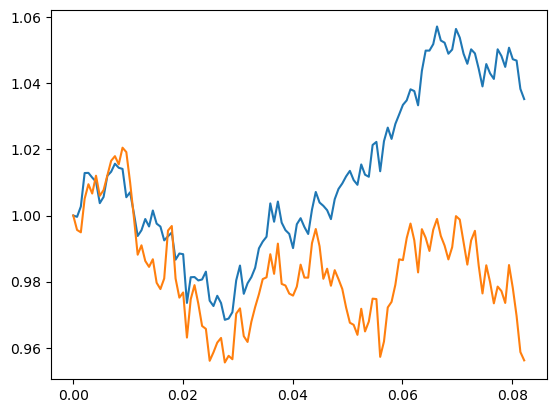

In [16]:
#torch.manual_seed(0)
batch_x, batch_y, timesteps, d = 200, 100, 120, 1
sigma, S0, T = 0.2, 1.0, 30./365 # Black Scholes parameters
theta, mu, std = 4, 0.0, .15


dt = T/timesteps
time_grid = torch.linspace(0.0, T, timesteps).view(1, -1, 1).expand([batch_x + batch_y, timesteps, d])

dW = np.sqrt(dt)*torch.randn(batch_x + batch_y, timesteps-1, d, 2)
W = torch.cat((torch.zeros(batch_x + batch_y, 1, d), dW[..., 0].cumsum(dim=1)), dim = 1)

X = S0*torch.exp(-0.5*(sigma**2)*time_grid + sigma*W).to(device)

Z = torch.zeros(X.shape).to(X.device.type)
for t in range(Z.shape[1]-1):
    Z[:, t+1, :] = Z[:, t, :] - theta*(mu - Z[:, t, :])*dt + std*dW[:, t, :, -1]


paths = torch.cat([X, X+Z], dim=-1)
train_paths = paths[:batch_x]
test_paths = paths[batch_x:]

plt.plot(torch.linspace(0.0, T, timesteps), train_paths[0].detach().cpu())
plt.show()

## Body

In [17]:
class SigKer(KernelCompute):
    def __init__(self):
        self.dyadic_order = 0
        self.Kernel_Class = sigkernel.SigKernel(sigkernel.LinearKernel(), dyadic_order=self.dyadic_order)
        self.scale = 2
        
    def compute_Gram(self, X, Y, sym=False):
        return self.Kernel_Class.compute_Gram(self.scale*X.double(),self.scale*Y.double(), sym=sym)[..., ::2**self.dyadic_order, ::2**self.dyadic_order]
    
    def K_Phi(self, X, time_augmented=False, max_batch=50):
        return super().K_Phi(X, time_augmented, max_batch)

In [18]:
Ker = SigKer()
sk_trade = KernelTrader(Ker,
                        device, time_augment=True)

sk_trade.pre_fit(train_paths)

In [19]:
sk_trade.fit(risk_aversion=0.5, regularisation=1e-5*sk_trade.Xi.norm())
sk_trade.compute_pnl(test_paths)

tensor(-0.0417, dtype=torch.float64)


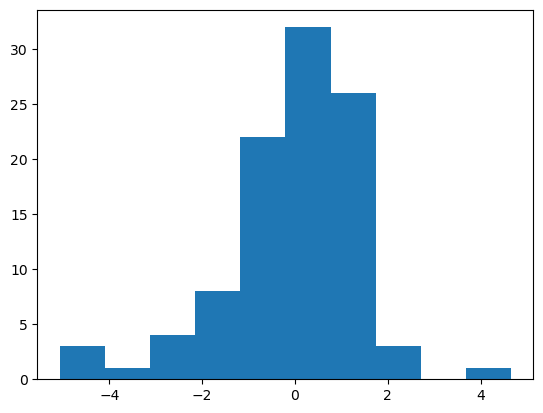

In [20]:
plt.hist(sk_trade.pnl[:,-1])
print(sk_trade.pnl[:,-1].mean())

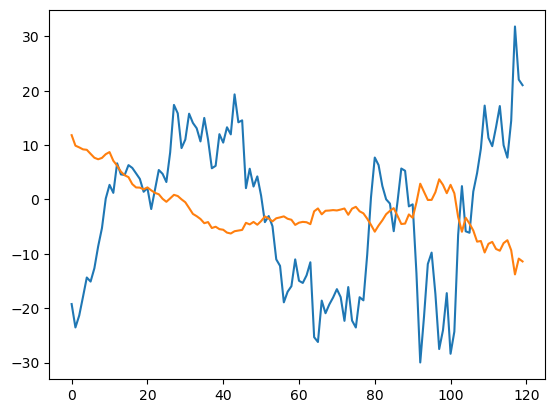

In [23]:
plt.plot(sk_trade.position[12])